In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import copy
import time
import random
import os
from PIL import Image
from IPython.display import display

import torch
import torchvision
from torch import nn, optim
from torchvision import models
from torch.functional import F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor']= 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['font.size']=12

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
data_dir = 'D:\\Projects\\Distracted Driver Detection\\State Farm Distracted Driver Detection\\'
labels = pd.read_csv(data_dir+'driver_imgs_list.csv')
sample_sub = pd.read_csv(data_dir+'sample_submission.csv')

display(labels.head())
display(sample_sub.head())

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [6]:
train_img_dir = os.path.join(data_dir, 'D:\\Projects\\Distracted Driver Detection\\State Farm Distracted Driver Detection\\train')
test_img_dir = os.path.join(data_dir, 'D:\\Projects\\Distracted Driver Detection\\State Farm Distracted Driver Detection\\test')

num_training_examples = 0
for fol in os.listdir(train_img_dir):
    num_training_examples += len(os.listdir(os.path.join(train_img_dir, fol)))

assert(num_training_examples == len(labels))
assert(len(os.listdir(test_img_dir)) == len(sample_sub))

In [7]:
train_data = torchvision.datasets.ImageFolder(root = train_img_dir)

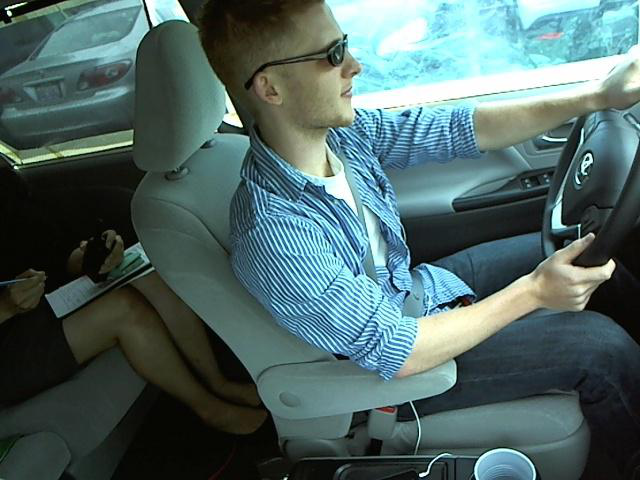

In [8]:
train_data[0][0]

In [9]:
labels.classname.map(train_data.class_to_idx)

0        0
1        0
2        0
3        0
4        0
        ..
22419    9
22420    9
22421    9
22422    9
22423    9
Name: classname, Length: 22424, dtype: int64

In [10]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f'{images[i][1]}')
        ax.imshow(np.array(images[i][0]))
        ax.axis('off')

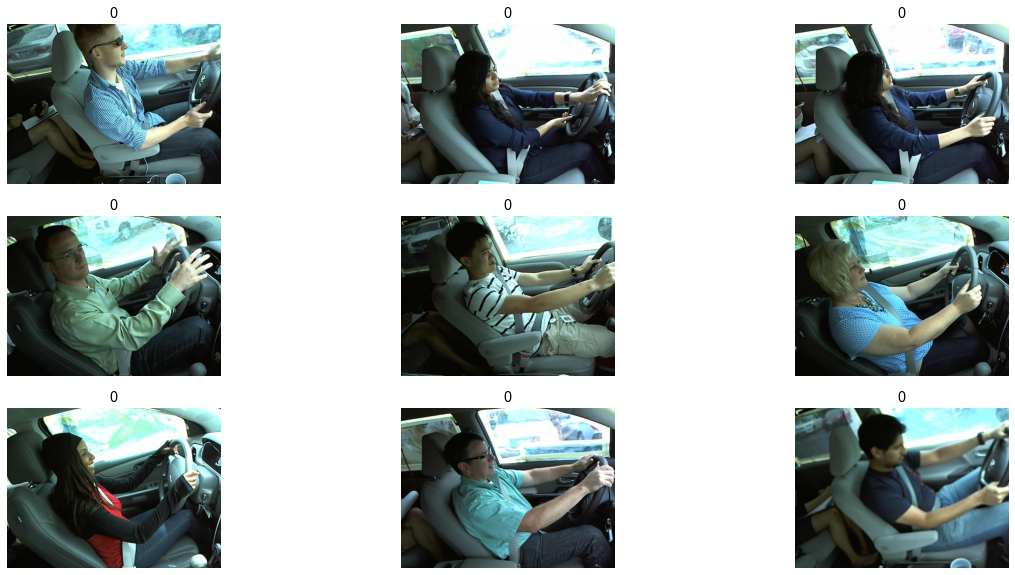

In [11]:
N_IMAGES = 9

images = [(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]] 
plot_images(images)

In [12]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [13]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
train_transforms = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
test_transforms = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

In [14]:
train_data.dataset.transform = train_transforms
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [15]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 20181
Number of validation examples: 2243


In [16]:
BATCH_SIZE = 256

train_iterator = DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE*2)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [18]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = Variable(torch.FloatTensor(np.array(x))).to(device)
        y = Variable(torch.LongTensor(y)).to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = Variable(torch.FloatTensor(np.array(x))).to(device)
            y = Variable(torch.LongTensor(y)).to(device)
        
            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
def fit_model(model, model_name, train_iterator, valid_iterator, optimizer, loss_criterion, device, epochs):
    """ Fits a dataset to model"""
    best_valid_loss = float('inf')
    
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    
    for epoch in range(epochs):
    
        start_time = time.time()
    
        train_loss, train_acc = train(model, train_iterator, optimizer, loss_criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_iterator, loss_criterion, device)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc*100)
        valid_accs.append(valid_acc*100)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{model_name}.pt')
    
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        
    return pd.DataFrame({f'{model_name}_Training_Loss':train_losses, 
                        f'{model_name}_Training_Acc':train_accs, 
                        f'{model_name}_Validation_Loss':valid_losses, 
                        f'{model_name}_Validation_Acc':valid_accs})

In [21]:
def plot_training_statistics(train_stats, model_name):
    
    fig, axes = plt.subplots(2, figsize=(15,15))
    axes[0].plot(train_stats[f'{model_name}_Training_Loss'], label=f'{model_name}_Training_Loss')
    axes[0].plot(train_stats[f'{model_name}_Validation_Loss'], label=f'{model_name}_Validation_Loss')
    axes[1].plot(train_stats[f'{model_name}_Training_Acc'], label=f'{model_name}_Training_Acc')
    axes[1].plot(train_stats[f'{model_name}_Validation_Acc'], label=f'{model_name}_Validation_Acc')
    
    axes[0].set_xlabel("Number of Epochs"), axes[0].set_ylabel("Loss")
    axes[1].set_xlabel("Number of Epochs"), axes[1].set_ylabel("Accuracy in %")
    
    axes[0].legend(), axes[1].legend()

In [23]:
model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
for name, param in model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

In [25]:
model= model.to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-2)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,808 trainable parameters


In [26]:
train_stats_ResNet18 = fit_model(model, 'ResNet18', train_iterator, valid_iterator, optimizer, loss_criterion, device, epochs=2)

Epoch: 01 | Epoch Time: 3m 43s
	Train Loss: 1.706 | Train Acc: 73.43%
	 Val. Loss: 0.445 |  Val. Acc: 88.17%
Epoch: 02 | Epoch Time: 2m 29s
	Train Loss: 0.121 | Train Acc: 97.97%
	 Val. Loss: 0.113 |  Val. Acc: 98.05%


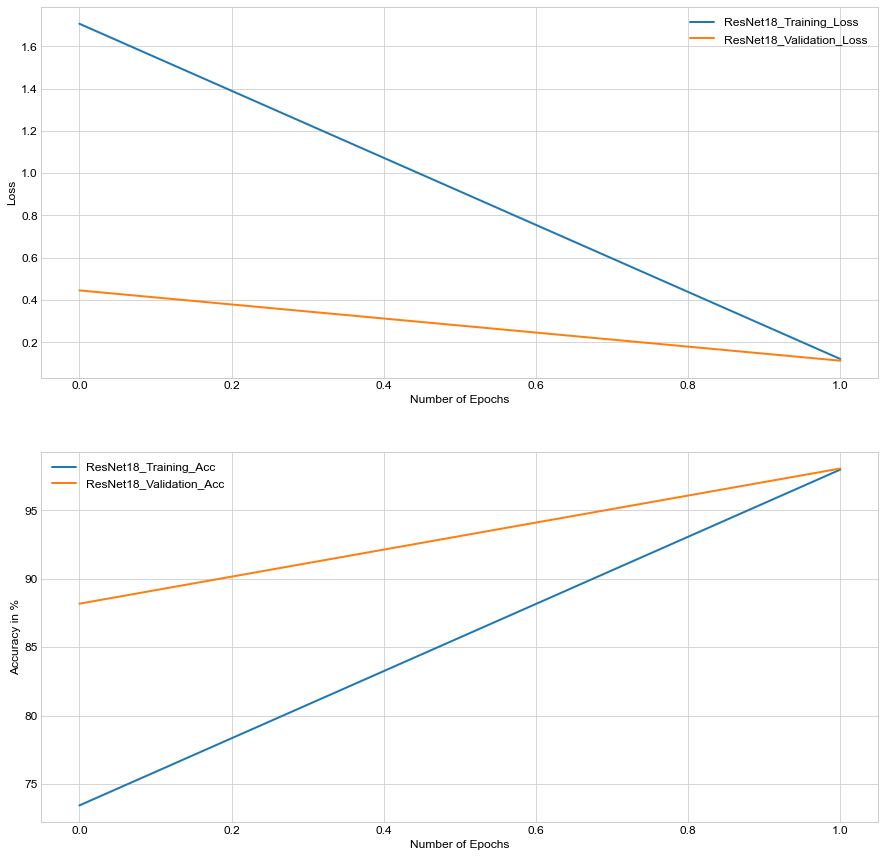

In [27]:
plot_training_statistics(train_stats_ResNet18, 'ResNet18')